<a href="https://colab.research.google.com/github/HSAkash/Potato-Leaf-Disease-Dataset/blob/main/potato_disease_test_data_up99_valid_data_98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import kaggle 
* **Dataset** : [Click](https://www.kaggle.com/datasets/muhammadardiputra/potato-leaf-disease-dataset)
* **Code** : [Click](https://www.kaggle.com/code/hsakash/potato-disease-test-data-99-67-valid-data-98)

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
# Kaggle authentication data(kaggle.json)
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadardiputra/potato-leaf-disease-dataset

 95% 24.0M/25.2M [00:00<00:00, 107MB/s] 
100% 25.2M/25.2M [00:00<00:00, 95.7MB/s]


## Unzip data

In [ ]:
! unzip potato-leaf-disease-dataset.zip

# Import Libraries

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import Data

## File path

In [9]:
train_dir = "Potato/Train"
test_dir = "Potato/Test"
valid_dir = "Potato/Valid"


"""From kaggle"""
# train_dir = "../input/potato-leaf-disease-dataset/Potato/Train"
# test_dir = "../input/potato-leaf-disease-dataset/Potato/Test"
# valid_dir = "../input/potato-leaf-disease-dataset/Potato/Valid"

'From kaggle'

## Data Rescaling and augmentation

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(224, 224, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
], name ="data_augmentation")

## Load datasets

### Shuffle and prefetch

In [11]:

import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True
).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

valid_datasets = tf.keras.preprocessing.image_dataset_from_directory(
    directory = valid_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
)

class_names = valid_datasets.class_names
valid_data = valid_datasets.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 900 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


## Visualizing data

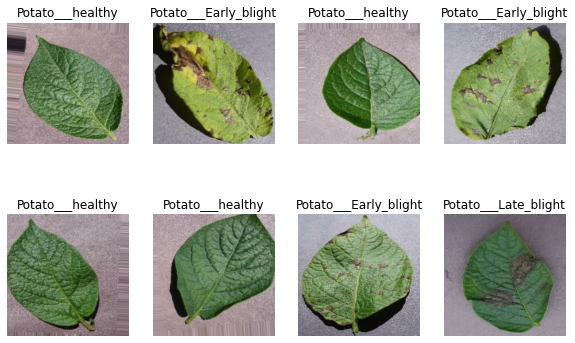

In [12]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    for i in range(0,8):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

### Augmented image view

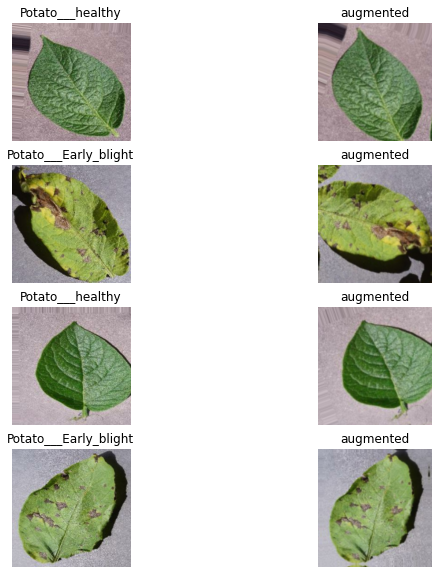

In [13]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        plt.imshow(augmented_image_batch[i])
        plt.title(f"augmented")
        plt.axis("off")

# Create Checkpoint

In [14]:
checkpoint_path = "CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

# Create model

In [15]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layers')

])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, None, None, 60)    1680      
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 60)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 60)    32460     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 60)   0         
 2D)                                                             
                                                        

# Compile model

In [17]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

# Fit the model

In [18]:
history = model.fit(
    train_data,
    epochs=200,
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback,
    ]
)

Epoch 1/200
29/29 [==============================] - 38s 883ms/step - loss: 1.0992 - accuracy: 0.3622 - val_loss: 1.2522 - val_accuracy: 0.3333
Epoch 2/200
29/29 [==============================] - 22s 756ms/step - loss: 1.0999 - accuracy: 0.3322 - val_loss: 1.0511 - val_accuracy: 0.3333
Epoch 3/200
29/29 [==============================] - 27s 931ms/step - loss: 0.9864 - accuracy: 0.5056 - val_loss: 0.7936 - val_accuracy: 0.6267
Epoch 4/200
29/29 [==============================] - 26s 898ms/step - loss: 0.8518 - accuracy: 0.5978 - val_loss: 0.6996 - val_accuracy: 0.7767
Epoch 5/200
29/29 [==============================] - 27s 907ms/step - loss: 0.6845 - accuracy: 0.6833 - val_loss: 1.2210 - val_accuracy: 0.4400
Epoch 6/200
29/29 [==============================] - 25s 870ms/step - loss: 0.7401 - accuracy: 0.6567 - val_loss: 0.6095 - val_accuracy: 0.7633
Epoch 7/200
29/29 [==============================] - 24s 840ms/step - loss: 0.5614 - accuracy: 0.7778 - val_loss: 0.4315 - val_accuracy:

### Plot history

In [19]:


# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()



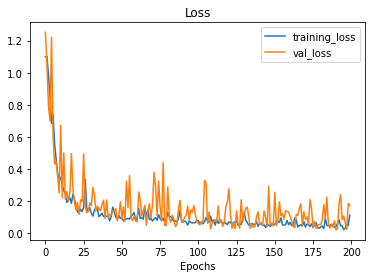

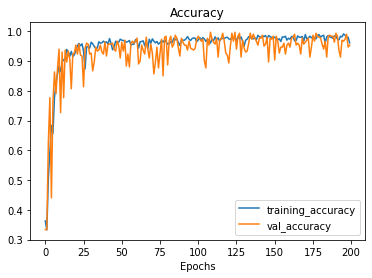

In [20]:
plot_loss_curves(history)

# Check best weight validation data percentance

In [21]:
def bestWeightModelEvaluate(model, weight_path, data):
  cp_model = tf.keras.models.clone_model(model)
  cp_model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
  )
  cp_model.load_weights(weight_path)
  cp_model.evaluate(data)

In [22]:
bestWeightModelEvaluate(
    model = model,
    weight_path= checkpoint_path,
    data = valid_data
)

10/10 [==============================] - 1s 31ms/step - loss: 0.0716 - accuracy: 0.9733


In [23]:
bestWeightModelEvaluate(
    model = model,
    weight_path= checkpoint_path,
    data = test_data
)

10/10 [==============================] - 0s 28ms/step - loss: 0.0263 - accuracy: 0.9967


# Download pretrain model

In [30]:
! wget "https://github.com/HSAkash/Potato-Leaf-Disease-Dataset/raw/main/potato_pretrain_model.h5"

--2022-08-17 14:56:38--  https://github.com/HSAkash/Potato-Leaf-Disease-Dataset/raw/main/potato_pretrain_model.h5
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HSAkash/Potato-Leaf-Disease-Dataset/main/potato_pretrain_model.h5 [following]
--2022-08-17 14:56:38--  https://raw.githubusercontent.com/HSAkash/Potato-Leaf-Disease-Dataset/main/potato_pretrain_model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 849224 (829K) [application/octet-stream]
Saving to: ‘potato_pretrain_model.h5’

potato_pretrain_mod 100%[===================>] 829.32K  --.-KB/s    in 0.008s  

2022-08-17 14:56:38 (103

## Load model

In [31]:
load_model = tf.keras.models.load_model("potato_pretrain_model.h5")

## summary of load data

In [32]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, None, None, 60)    1680      
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 60)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 60)    32460     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 60)   0         
 2D)                                                             
                                                        

## Main model summary.
main model and load model are save

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, None, None, 60)    1680      
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 60)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 60)    32460     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 60)   0         
 2D)                                                             
                                                        

## Evaluate load model with valid data and test_data

In [34]:
load_model.evaluate(test_data)

10/10 [==============================] - 0s 31ms/step - loss: 0.0424 - accuracy: 0.9967


[0.042373042553663254, 0.996666669845581]

In [35]:
load_model.evaluate(valid_data)

10/10 [==============================] - 0s 31ms/step - loss: 0.0707 - accuracy: 0.9800


[0.07074111700057983, 0.9800000190734863]

## Prediction && visualize

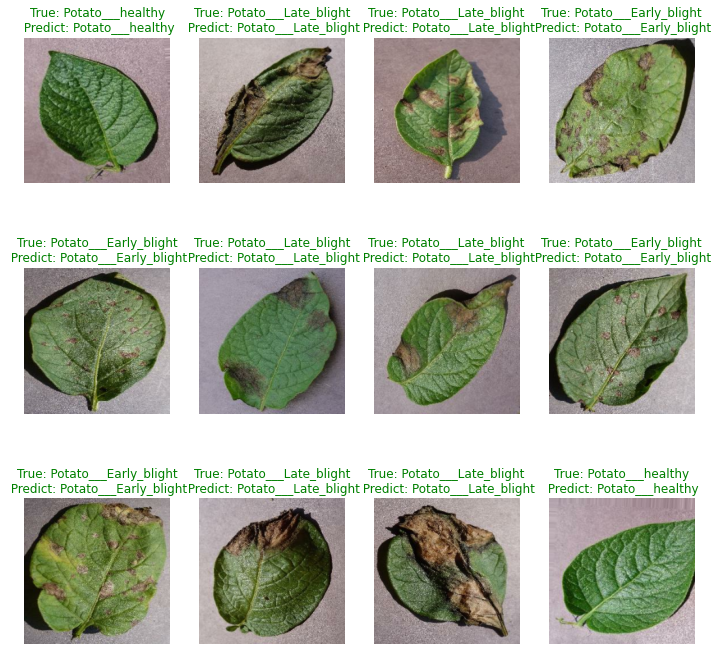

In [36]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,12))
for image_batch,label_batch in test_data.take(1):
    predictions = load_model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")
